In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)
plt.rcParams['font.family'] = 'Yu Gothic'

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [3]:
df2 = my_modules.preprocessing(df)

In [4]:
df3 = my_modules.common_process(df2)

C:\Users\ken05\Documents\others\HORSE_RACING\Modules\my_modules.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["place_num"] = df["place"].replace(place_dict).astype(int)


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 67 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

In [6]:
df3.head()

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,sample_weight,target,target3
252634,202001050601010115,2020,1,5,1,中山,1,1,ラブカワールド,1177,1131,16,8,15,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,436.0,4.0,3,474.2,153.0,39.3,13,2.0,1153.0,NaN,NaN,15.0,16.0,39.9,9,35.4,38.7,40.57,36.0,1.5,後方,15.0,0,0,トゥザワールド,ラブカテリーナ,オレハマッテルゼ,ロイヤルチャージャー系,黒鹿,2017104350,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0.0625,0,0
252635,202001050601010116,2020,1,5,1,中山,1,1,シラカワカツコ,1173,1031,16,8,16,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,404.0,4.0,3,233.1,83.6,21.6,14,2.1,1154.0,NaN,NaN,9.0,10.0,40.4,13,35.0,36.6,40.57,36.0,1.1,中団,13.0,0,0,ディープブリランテ,シャイニングピサ,Smart Strike,ネイティヴダンサー系,鹿毛,2017101747,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0.0625,0,0
252633,202001050601010102,2020,1,5,1,中山,1,1,スルーザリミッツ,1122,1118,16,1,2,7,24,2,1200,良,晴,12,牝,3,54.0,NaN,424.0,-4.0,3,31.4,13.7,3.9,12,1.6,1149.0,NaN,NaN,16.0,15.0,39.3,6,35.6,40.6,40.57,36.0,1.7,後方,7.0,0,0,パイロ,ファービヨンド,ディープスカイ,ロイヤルチャージャー系,黒鹿,2017101861,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,splint,0.0625,0,0
252632,202001050601010104,2020,1,5,1,中山,1,1,セルレア,1161,1115,16,2,4,7,24,2,1200,良,晴,12,牝,3,53.0,NaN,464.0,10.0,3,14.5,7.3,2.2,11,1.6,1149.0,NaN,NaN,6.0,6.0,40.2,11,34.7,36.3,40.57,36.0,0.8,中団,4.0,0,0,ロードカナロア,ダイワミストレス,ダイワメジャー,ロイヤルチャージャー系,鹿毛,2017102095,2020010506010101,ダート,平地,R,中山ダート1200,inner,2020-01-05 01:02:00,3,splint,0.0625,0,0
252631,202001050601010109,2020,1,5,1,中山,1,1,サノレーヌ,1164,1141,16,5,9,7,24,2,1200,良,晴,12,牝,3,51.0,NaN,438.0,0.0,3,9.5,4.5,1.5,10,1.5,1148.0,NaN,NaN,1.0,1.0,40.9,15,33.9,32.9,40.57,36.0,0.0,逃げ,3.0,0,0,サウスヴィグラス,アニマートホウヨウ,フサイチコンコルド,ニアークティック系,鹿毛,2017100847,2020010506010101,ダート,平地,R,中山ダート1200,outer,2020-01-05 01:02:00,3,splint,0.0625,0,0


In [ ]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill is in progress
calculating EloRating is in progress
calculating Glicko2 is in progress
poly calculated
calc grouped rating caluculated
group_winning_rate_calculated
added last odds


<string>:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<string>:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

calculated rankings
['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'age_type', 'dist_type', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'num_of_entries', '後方_per_entries', '後方_cumcount_past_racing', '中団_per_entries', '中団_cumcount_past_racing', '逃げ_per_entries', '逃げ_cumcount_past_racing', '先行_per_entries', '先行_cumcount_past_racing', 'ﾏｸﾘ_per_entries', 'ﾏｸﾘ_cumcount_past_racing', 'past_rank_mean', 'past_rank_mean_grouped_dist_type', 'past_rank_mean_grouped_dist', 'past_rank_mean_grouped_class_code', 'past_rank_mean_grouped_place', 'past_corner1_rank_mean', 'past_corner1_rank_mean_groupe

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,sample_weight,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jo

In [10]:
print(df4.shape)
df4.head()

(252411, 405)


,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_mul_odds_Hi,win_mul_odds_Lo,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,age_type,dist_type,sample_weight,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,中団,先行,後方,逃げ,ﾏｸﾘ,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,horse_TrueSkill_after_racing,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,jockey_TrueSkill_after_racing,horse_EloRating,horse_EloRating_after_racing,jockey_EloRating,jockey_EloRating_after_racing,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_Glicko2_after_racing,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jo

In [11]:
df4[feature_col2].tail()

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,age_type,dist_type,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,num_of_entries,後方_per_entries,後方_cumcount_past_racing,中団_per_entries,中団_cumcount_past_racing,逃げ_per_entries,逃げ_cumcount_past_racing,先行_per_entries,先行_cumcount_past_racing,ﾏｸﾘ_per_entries,ﾏｸﾘ_cumcount_past_racing,past_rank_mean,past_rank_mean_grouped_dist_type,past_rank_mean_grouped_dist,past_rank_mean_grouped_class_code,past_rank_mean_grouped_place,past_corner1_rank_mean,past_corner1_rank_mean_grouped_dist_type,past_corner1_rank_mean_grouped_dist,past_corner2_rank_mean,past_corner2_rank_mean_grouped_dist_type,past_corner2_rank_mean_grouped_dist,past_corner3_rank_mean,past_corner3_rank_mean_grouped_dist_type,past_corner3_rank_mean_grouped_dist,past_corner4_rank_mean,past_corner4_rank_mean_grouped_dist_type,past_corner4_rank_mean_grouped_dist,past_pop_mean,past_pop_mean_grouped_dist,past_pop_mean_grouped_dist_type,past_pop_mean_grouped_place,past_pop_mean_grouped_class_code,past_last_3F_rank_mean,past_last_3F_rank_mean_grouped_dist,past_last_3F_rank_mean_grouped_dist_type,basis_weight_per_weight,basis_weight_plus_weight,inc_dec_rate,lifetime_prize,lifetime_prize_per_race,is_same_field_type_as_last,is_same_class_code_as_last,is_same_jockey_as_last,interval_day,horse_TrueSkill,horse_TrueSkill_sigma,horse_TrueSkill_min,horse_TrueSkill_max,jockey_TrueSkill,jockey_TrueSkill_sigma,jockey_TrueSkill_min,jockey_TrueSkill_max,horse_EloRating,jockey_EloRating,horse_Glicko2,horse_Glicko2_RD,horse_Glicko2_min,horse_Glicko2_max,horse_TrueSkill_diff_from_last1_racing,horse_TrueSkill_diff_from_last3_racing,jockey_TrueSkill_diff_from_last1_racing,jockey_TrueSkill_diff_from_last3_racing,horse_EloRating_diff_from_last1_racing,horse_EloRating_diff_from_last3_racing,jockey_EloRating_diff_from_last1_racing,jockey_EloRating_diff_from_last3_racing,horse_Glicko2_diff_from_last1_racing,horse_Glicko2_diff_from_last3_racing,horse_TrueSkill horse_TrueSkill_min,horse_TrueSkill horse_TrueSkill_max,horse_TrueSkill jockey_TrueSkill,horse_TrueSkill jockey_TrueSkill_min,horse_TrueSkill jockey_TrueSkill_max,horse_TrueSkill horse_EloRating,horse_TrueSkill jockey_EloRating,horse_TrueSkill horse_Glicko2,horse_TrueSkill horse_Glicko2_min,horse_TrueSkill horse_Glicko2_max,horse_TrueSkill_min horse_TrueSkill_max,horse_TrueSkill_min jockey_TrueSkill,horse_TrueSkill_min jockey_TrueSkill_min,horse_TrueSkill_min jockey_TrueSkill_max,horse_TrueSkill_min horse_EloRating,horse_TrueSkill_min jockey_EloRating,horse_TrueSkill_min horse_Glicko2,horse_TrueSkill_min horse_Glicko2_min,horse_TrueSkill_min horse_Glicko2_max,horse_TrueSkill_max jockey_TrueSkill,horse_TrueSkill_max jockey_TrueSkill_min,horse_TrueSkill_max jockey_TrueSkill_max,horse_TrueSkill_max horse_EloRating,horse_TrueSkill_max jockey_EloRating,horse_TrueSkill_max horse_Glicko2,horse_TrueSkill_max horse_Glicko2_min,horse_TrueSkill_max horse_Glicko2_max,jockey_TrueSkill jockey_TrueSkill_min,jockey_TrueSkill jockey_TrueSkill_max,jockey_TrueSkill horse_EloRating,jockey_TrueSkill jockey_EloRating,jockey_TrueSkill horse_Glicko2,jockey_TrueSkill horse_Glicko2_min,jockey_TrueSkill horse_Glicko2_max,jockey_TrueSkill_min jockey_TrueSkill_max,jockey_TrueSkill_min horse_EloRating,jockey_TrueSkill_min jockey_EloRating,jockey_TrueSkill_min horse_Glicko2,jockey_TrueSkill_min horse_Glicko2_min,jockey_TrueSkill_min horse_Glicko2_max,jockey_TrueSkill_max horse_EloRating,jockey_TrueSkill_max jockey_EloRating,jockey_TrueSkill_max horse_Glicko2,jockey_TrueSkill_max horse_Glicko2_min,jockey_TrueSkill_max horse_Glicko2_max,horse_EloRating jockey_EloRating,horse_EloRating horse_Glicko2,horse_EloRating horse_Gli

[I 2025-06-30 07:50:00,201] A new study created in memory with name: no-name-414e372e-567c-4abc-8005-fc3627236e91
[I 2025-06-30 07:50:08,477] Trial 0 finished with value: 0.23243591070586694 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.41472250004816347, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.23243591070586694.
[I 2025-06-30 07:50:19,591] Trial 1 finished with value: 0.22372360685560203 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lamb

Best params :  {'max_bin': 162, 'num_leaves': 87, 'min_data_in_leaf': 25, 'min_sum_hessian_in_leaf': 7.222506684840725, 'bagging_fraction': 0.8481866352774331, 'bagging_freq': 47, 'feature_fraction': 0.5372030756211171, 'lambda_l1': 5.064312324740649e-07, 'lambda_l2': 0.023899480382354746, 'min_gain_to_split': 0.08890595863639007, 'max_depth': 40, 'learning_rate': 0.003733869119537278, 'path_smooth': 8.62602078140185}


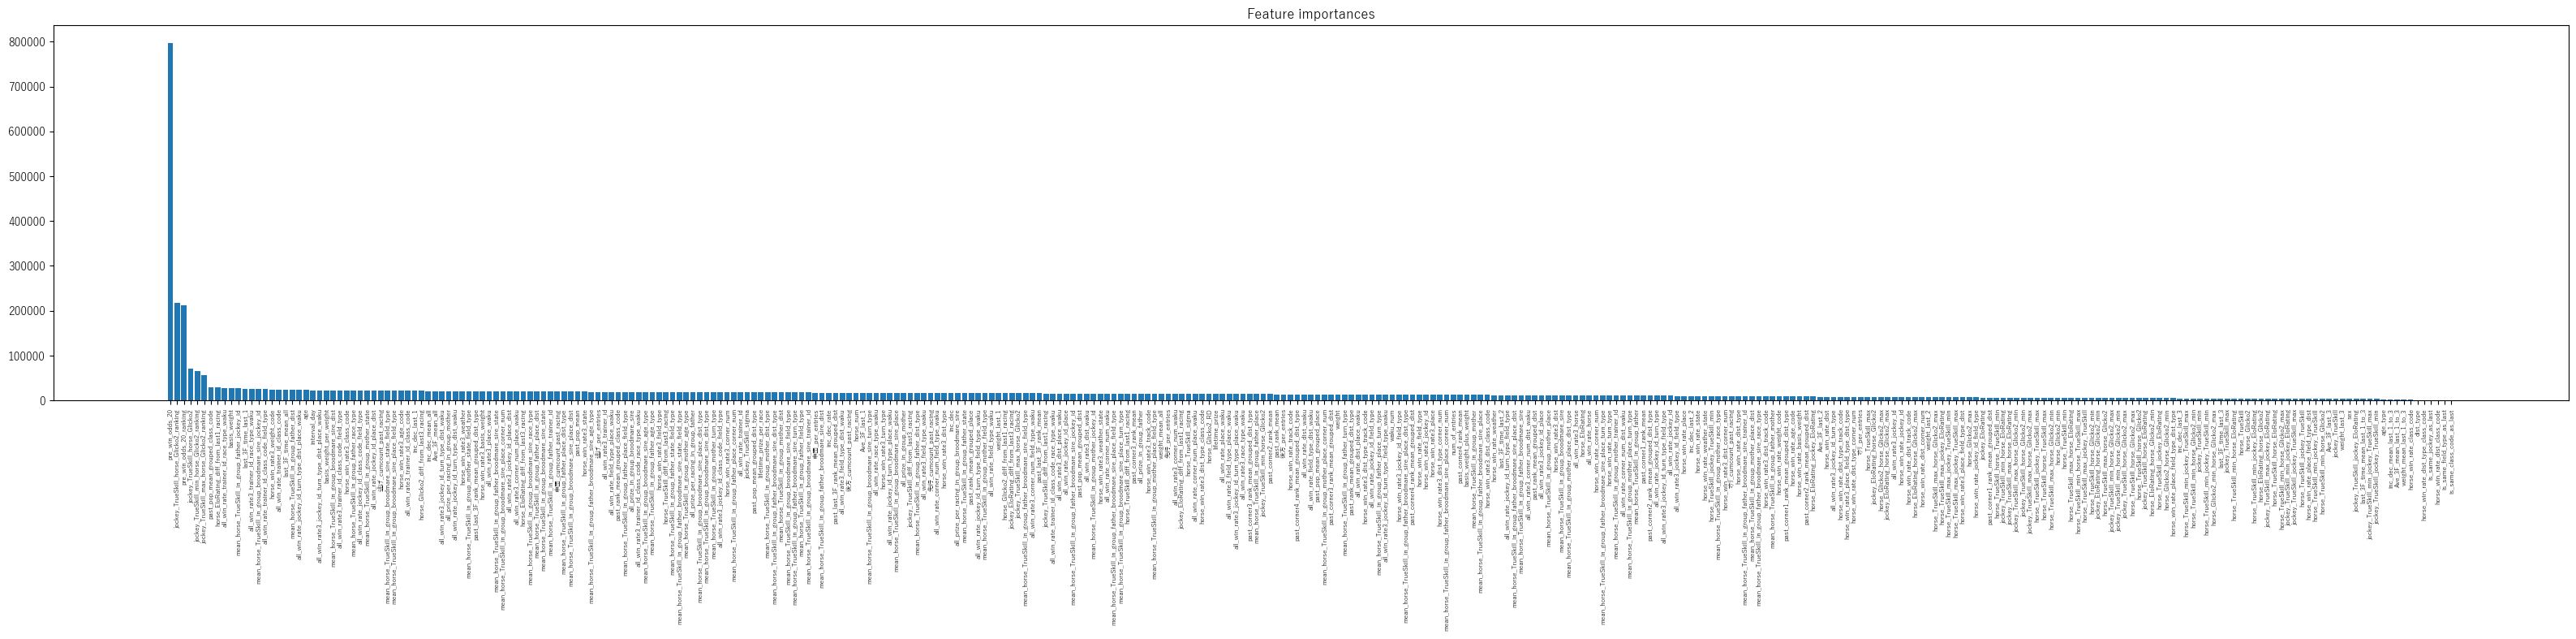

,date,memo,horse_5,horse_6,horse7,horse_8,horse_9,horse_10,horse_11,horse_12,horse_13,horse_14,horse_15,horse_16,horse_17,horse_18,sum_of_logloss,roc_auc_score
0,2025/06/30 08:20,revise calc_leg_cumsum. n_rials=50.,0.272178,0.311194,0.289438,0.316800,0.280948,0.257478,0.238342,0.223744,0.218380,0.215123,0.199726,0.187097,0.176741,0.178706,3.365893,0.827063
1,2025/06/29 19:34,revise calc_leg_cumsum. n_rials=50.,0.248486,0.318535,0.304798,0.318809,0.286193,0.261016,0.241637,0.224858,0.217707,0.214855,0.200058,0.189101,0.178341,0.177638,3.382032,0.824746
2,2025/06/29 18:21,"re-add odds information, add leg features and ...",0.276185,0.340398,0.291840,0.293379,0.278227,0.262498,0.226381,0.212892,0.207240,0.199117,0.187899,0.178427,0.159943,0.171601,3.286027,0.851652
3,2025/06/29 16:44,"reduce odds information, add polynomial-skill-...",0.245772,0.326162,0.302924,0.328790,0.295388,0.263602,0.248498,0.226110,0.230588,0.224340,0.211798,0.199279,0.189901,0.182976,3.476126,0.796616
4,2025/06/29 15:26,add polinomial-skill-features and calibrated. ...,0.255945,0.307037,0.291056,0.308091,0.282382,0.257668,0.237284,0.225000,0.218382,0.219319,0.203053,0.191489,0.178167,0.179095,3.353968,0.817733


In [12]:
memo = "revise calc_leg_cumsum. n_rials=50."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=50, save_result=True, visualization=True)

In [21]:
tmp = df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
246982,2025050405020408,カニキュル,0.704027
233200,2025012506010806,クレーキング,0.641612
221870,2024102008050609,サブマリーナ,0.634916
222190,2024102605040706,キャネル,0.610275
235032,2025020805010303,アドマイヤデイトナ,0.601152
246923,2025050408020406,タマモナポリ,0.595481
242821,2025040506030309,ピックデムッシュ,0.561902
248282,2025051704010504,ハミルトン,0.561447
227947,2024120808070403,モンテシート,0.550579
223428,2024110308060203,レッドシュテルン,0.549855


In [14]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
242712,2025040506030305,アイスフィールド,6.670298e-16
242734,2025040509020305,ウィッシュソング,6.616281e-16
251244,2025060809030207,フルオブエナジー,6.352443e-16
248304,2025051705020705,レオプレセア,6.118739e-16
247317,2025051005020505,パリモード,5.199877e-16


In [15]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)

In [16]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_curve(df, y_true_col="target", y_pred_col="pred", title="Calibration curve"):
    y_true = df[y_true_col]
    y_pred = df[y_pred_col]

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=20, strategy='uniform')

    # 件数を計算
    bin_edges = np.linspace(0, 1, 21)  # n_bins+1個のbin境界
    bin_ids = np.digitize(y_pred, bin_edges) - 1 # どのbinに属するか（0～19）

    counts = []
    for i in range(20):
        counts.append(np.sum(bin_ids == i))

    # グラフ描画
    plt.plot(prob_pred, prob_true, marker="o", markersize=4)
    plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7, color="black")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.title(title)

    # 件数をマーカー上に表示
    for x, y, count in zip(prob_pred, prob_true, counts):
        plt.text(x, y + 0.02, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


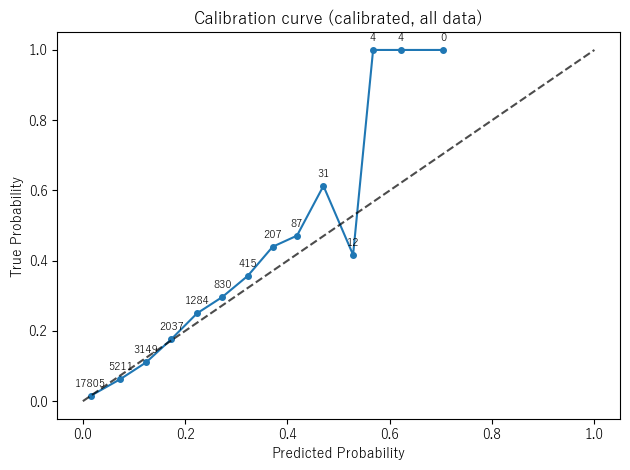

In [17]:
plot_calibration_curve(df_pred, title="Calibration curve (calibrated, all data)")

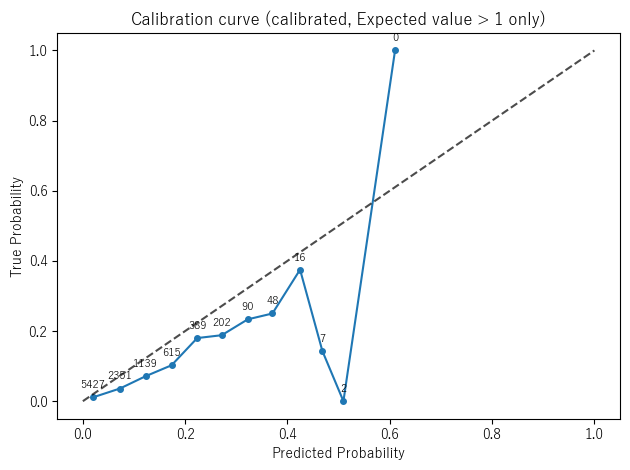

In [18]:
df_pred["exp_value"] = df_pred["win_odds"] * df_pred["pred"]
plot_calibration_curve(df_pred[df_pred["exp_value"] > 1], title="Calibration curve (calibrated, Expected value > 1 only)")

In [19]:
def buy_high_exp_value_ticket(df):
    df = df.copy()
    df["buy_ticket_flg"] = (df["exp_value"] > 1).astype(int)
    ticket_sum = df["buy_ticket_flg"].sum()
    ticket_price = 100
    buy_amount = ticket_sum * ticket_price
    win_amount = (df["buy_ticket_flg"] * df["target"] * df["win_odds"]).sum() * ticket_price
    print("合計購入点数:", ticket_sum)
    print("購入金額:", buy_amount)
    print("払戻金額:", win_amount)
    print("ROI: {}%".format(round(win_amount/buy_amount * 100, 2)))

In [20]:
buy_high_exp_value_ticket(df_pred)

合計購入点数: 10287
購入金額: 1028700
払戻金額: 781190.0
ROI: 75.94%
